# UIUC Grid Demand: Prediction Uncertainty

This notebook checks the uncertainty in the prediction by running several simulations using different random states.

Note: The parameters are optimized for a random seed of 85. The "uncertainty" comes from the parameters being sub-optimal for other random seeds.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, "/home/dotson/research/cairo")


# custom libraries
from tools import MSE, esn_prediction, param_string, optimal_values
from optimizers import grid_optimizer
from sunrise import generate_elevation_series
from pyESN.pyESN import ESN

In [2]:
# import demand data
dataframe = pd.read_csv("../data/uiuc_demand_data.csv", usecols=['time','kw'])
demand = np.array(dataframe.kw).astype('float64')

# normalize
norm = np.linalg.norm(demand)
demand_norm = demand/norm

In [3]:
time_range = pd.date_range(start='1/1/2015', end='7/1/2019', freq='h')[:-2]
elevation = generate_elevation_series(time_range, timestamps=True)
norm_a = np.linalg.norm(elevation)
angles_norm = elevation/norm_a
print(f"Norm of elevation angles: {norm_a}")
print(f"Norm of demand: {norm}")

Norm of elevation angles: 7170.040655802196
Norm of demand: 10142199.043147163


## Format the Input Data

In [4]:
X_in = np.concatenate([[demand_norm, angles_norm]], axis=1)
    
print(f"Shape of X_in is {X_in.shape}")

Shape of X_in is (2, 39407)


### Optimal Parameters Obtained from Demand-Solarangle

In [5]:
rand_seeds = [85, 21, 22, 30, 122, 5, 79]

# Debugging Parameters
# params = {'n_reservoir':600, 
#           'sparsity':0.1, 
#           'rand_seed':85, 
#           'rho':1.5, 
#           'noise':0.0001, 
#           'future':72, 
#           'window':None, 
#           'trainlen':2000}

params = {'n_reservoir':4000, 
          'sparsity':0.1, 
          'rand_seed':85, 
          'rho':1.5, 
          'noise':0.0001, 
          'future':72, 
          'window':None, 
          'trainlen':23800}

In [6]:
futureTotal = params['future']
time_range = np.array(dataframe.time)
hour_range = np.arange(0, len(time_range), 1)

In [7]:
N = len(rand_seeds)
predictions = np.ones((N, futureTotal))


tic = time.perf_counter()
for x, seed in enumerate(rand_seeds):
    print(f"Running Simulation {x}")
    params['rand_seed'] = seed
    prediction = esn_prediction(X_in.T, params)
    predictions[x] = prediction.T[0]
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

Running Simulation 0
Running Simulation 1
Running Simulation 2
Running Simulation 3
Running Simulation 4
Running Simulation 5
Running Simulation 6
This simulation took 1468.38 seconds
This simulation took 24.47 minutes


In [8]:
mean_prediction = np.mean(predictions, axis=0)
len(mean_prediction)

72

In [9]:
std_prediction = np.std(predictions, axis=0)
len(std_prediction)

72

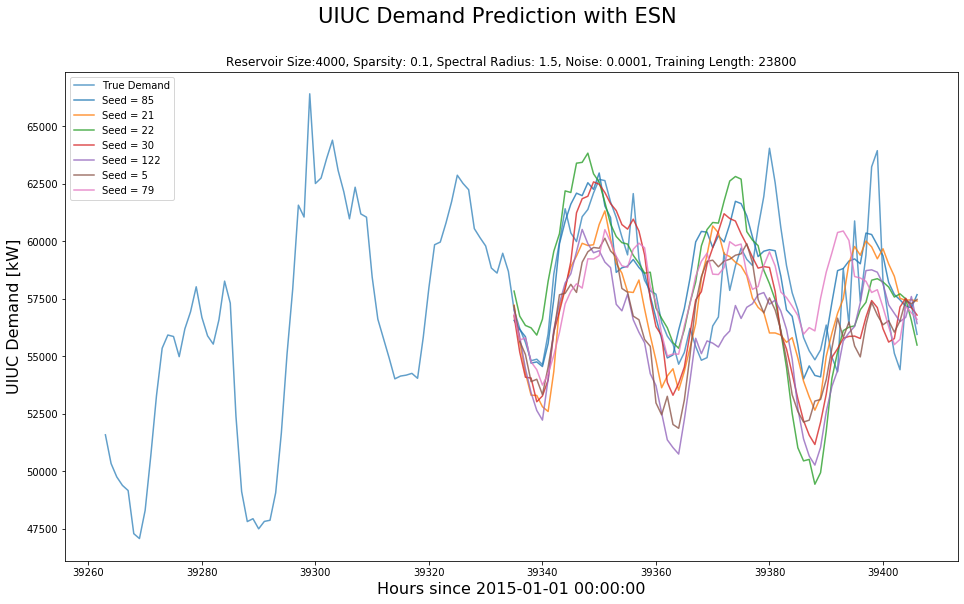

In [10]:
plt.figure(figsize=(16,9), facecolor='w')
plt.suptitle("UIUC Demand Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Demand [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
plt.plot(hour_range[-2*futureTotal:],norm*demand_norm[-2*futureTotal:],'b',label="True Demand", 
         alpha=0.7,
         color='tab:blue')
for seed, pred in zip(rand_seeds,predictions):
    plt.plot(hour_range[-futureTotal:], norm*pred,  alpha=0.8, 
         label=f'Seed = {seed}',
         linestyle='-')
plt.legend()

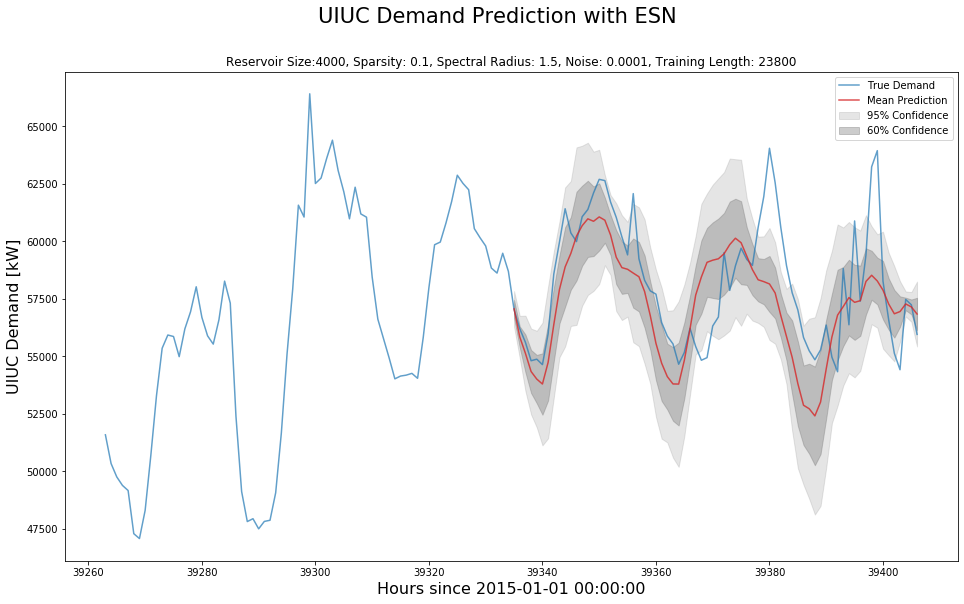

In [12]:
plt.figure(figsize=(16,9), facecolor='w')
plt.suptitle("UIUC Demand Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Demand [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
plt.plot(hour_range[-2*futureTotal:],norm*demand_norm[-2*futureTotal:],'b',label="True Demand", 
         alpha=0.7,
         color='tab:blue')
plt.plot(hour_range[-futureTotal:], norm*mean_prediction,  alpha=0.8, 
     label='Mean Prediction',
     color='tab:red',
     linestyle='-')
plt.fill_between(hour_range[-futureTotal:], 
                 norm*(mean_prediction + 2*std_prediction), 
                 norm*(mean_prediction - 2*std_prediction),
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(hour_range[-futureTotal:], 
                 norm*(mean_prediction + std_prediction), 
                 norm*(mean_prediction - std_prediction),
                 color='gray', alpha=0.4, label='60% Confidence')
plt.legend()